# Rank Countries by Confirmed Cases
---

## 00. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from adjustText import adjust_text

%matplotlib inline

## 01. Settings

In [3]:
TS_CONFIRMED = "../data/hopkins/time_series-ncov-Confirmed.csv"
TS_DEATHS = "../data/hopkins/time_series-ncov-Deaths.csv"
TS_RECOVERED = "../data/hopkins/time_series-ncov-Recovered.csv"
COLUMN_NAMES = [
    "province_state",
    "country_region",
    "lat",
    "lon",
    "date",
    "value"
]

## 02. Load data

In [4]:
df_confirmed = pd.read_csv(TS_CONFIRMED, skiprows=2, names=COLUMN_NAMES)
df_deaths = pd.read_csv(TS_DEATHS, skiprows=2, names=COLUMN_NAMES)
df_recovered = pd.read_csv(TS_RECOVERED, skiprows=2, names=COLUMN_NAMES)

df_confirmed.rename(columns = {'value':'confirmed'}, inplace = True)
df_deaths.rename(columns = {'value':'deaths'}, inplace = True)
df_recovered.rename(columns = {'value':'recovered'}, inplace = True)

df = df_confirmed
df = df.join(df_deaths[['deaths']])
df = df.join(df_recovered[['recovered']])

In [5]:
df.head()

,province_state,country_region,lat,lon,date,confirmed,deaths,recovered
0,NaN,Afghanistan,33.0,65.0,2020-03-22,40,1,1
1,NaN,Afghanistan,33.0,65.0,2020-03-21,24,0,1
2,NaN,Afghanistan,33.0,65.0,2020-03-20,24,0,1
3,NaN,Afghanistan,33.0,65.0,2020-03-19,22,0,1
4,NaN,Afghanistan,33.0,65.0,2020-03-18,22,0,1


## 03. Countries with the highest number of confirmed cases

In [6]:
date = df['date'].max()

In [7]:
top_confirmed = df \
[df['date'] == date] \
[['country_region', 'confirmed']] \
.groupby('country_region', as_index=False).sum() \
.sort_values('confirmed', ascending=False) \
.head(16) \
['country_region'] \
.values

list(top_confirmed)

['China',
 'Italy',
 'US',
 'Spain',
 'Germany',
 'Iran',
 'France',
 'Korea, South',
 'Switzerland',
 'United Kingdom',
 'Netherlands',
 'Belgium',
 'Austria',
 'Norway',
 'Sweden',
 'Portugal']

## 04. Single country time series

In [8]:
country_df = df \
[df['country_region'] == 'Italy'] \
[['date', 'confirmed']] \
.groupby('date', as_index=False).sum() \
.sort_values('date')

country_df = country_df[country_df['confirmed'] > 0]
country_df['confirmed_diff'] = country_df['confirmed'].diff()
country_df['confirmed_diff'].iloc[0] = country_df['confirmed'].iloc[0]
country_df.reset_index(inplace=True)

country_df.head()

,index,date,confirmed,confirmed_diff
0,9,2020-01-31,2,2.0
1,10,2020-02-01,2,0.0
2,11,2020-02-02,2,0.0
3,12,2020-02-03,2,0.0
4,13,2020-02-04,2,0.0


In [9]:
def process_by_country(df: pd.DataFrame, name: str):
    country_df = df \
    [df['country_region'] == name] \
    [['date', 'confirmed']] \
    .groupby('date', as_index=False).sum() \
    .sort_values('date')

    country_df = country_df[country_df['confirmed'] > 0]
    country_df['confirmed_diff'] = country_df['confirmed'].diff()
    country_df['confirmed_diff'].iloc[0] = country_df['confirmed'].iloc[0]
    country_df.reset_index(inplace=True)
    
    index = np.array(country_df.index)
    confirmed = country_df['confirmed'].values
    confirmed_diff = country_df['confirmed_diff'].values
    
    return index, confirmed, confirmed_diff

## 05. Make plot

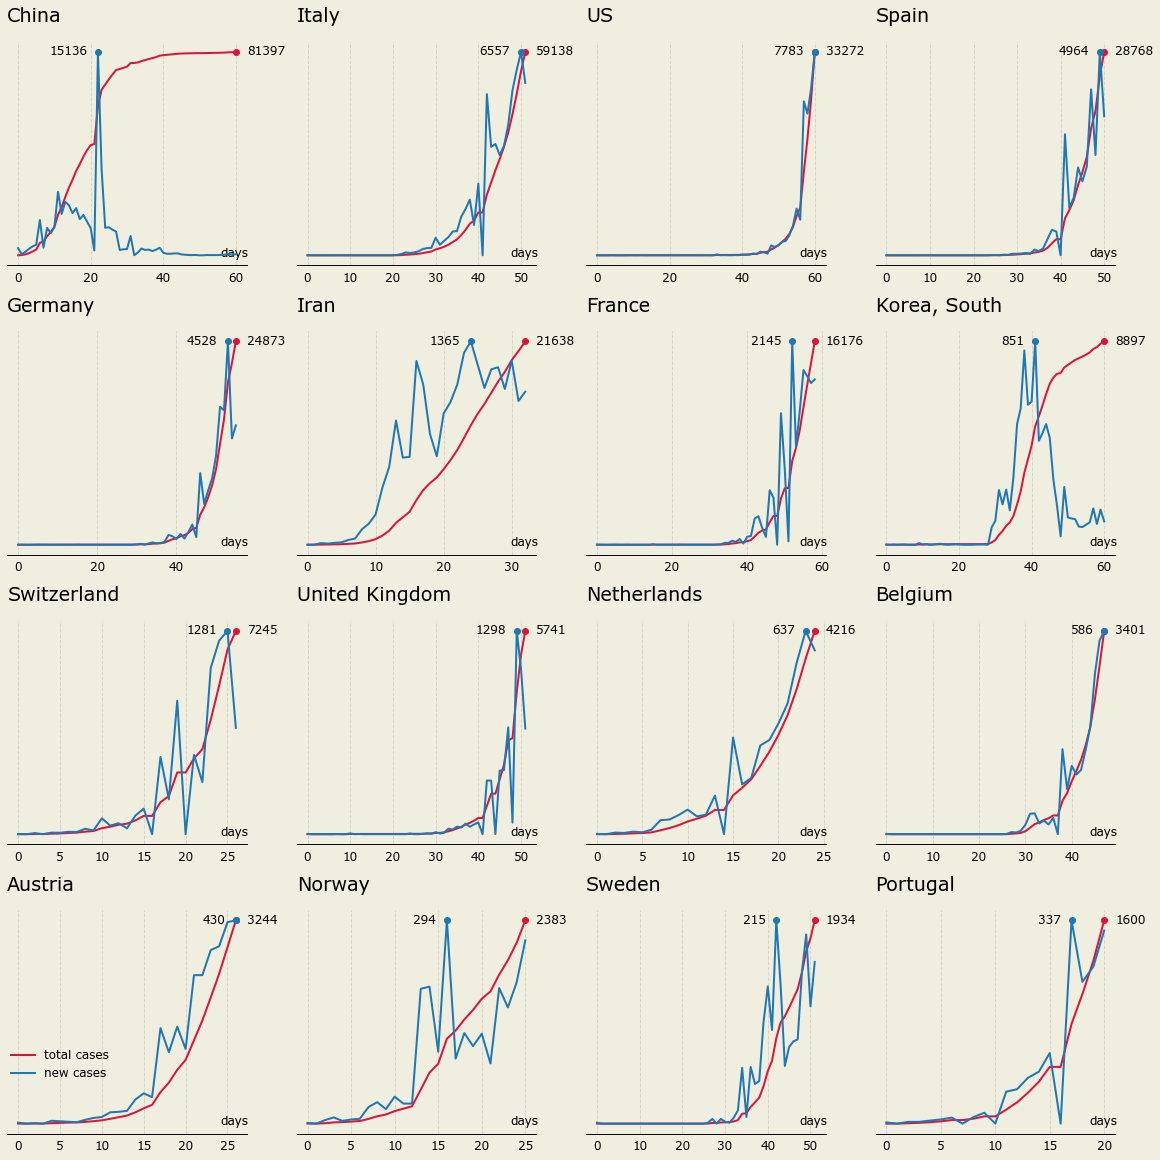

In [53]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']

grid_size = (4, 4)
fig_size = (16, 16)
countries = top_confirmed
br_color = (240 / 255, 238 / 255, 223 / 255)

fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=fig_size, constrained_layout=True, facecolor=br_color)

for ax1, country in zip(axes.flat, countries):
    x, y1, y2 = process_by_country(df, country)
    
    # line plots
    ax1.plot(x, y1, label = "total cases", color='crimson', linewidth=2)
    ax2 = ax1.twinx()
    ax2.plot(x, y2, label = "new cases", linewidth=2)
    
    rcParams['font.size'] = 16
    
    ax1.set_title(country, loc='left', pad=20)
    
    # axis style
    for s in ['top','left','right']:
        ax1.spines[s].set_visible(False)
        ax2.spines[s].set_visible(False)

    ax1.xaxis.set_ticks_position('none')
    ax2.xaxis.set_ticks_position('none')
    
    ax1.set_yticks([])
    ax2.set_yticks([])
    
    ax1.set_xlabel('days', fontsize = 12)
    ax1.xaxis.set_label_coords(0.95, 0.08)
    
    ax1.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
    
    # annotation
    xmax1 = x[np.argmax(y1)]
    ymax1 = y1.max()
    
    ax1.scatter([xmax1], [ymax1], color='crimson')
    
    xmax2 = x[np.argmax(y2)]
    ymax2 = y2.max()
    
    ax2.scatter([xmax2], [ymax2])
    
    rcParams['font.size'] = 12
    
    texts = []
    
    x_delta = xmax1 * 0.05
    
    texts.append(ax1.text(xmax1 + x_delta, ymax1, str(int(ymax1)), verticalalignment='center', horizontalalignment='left'))
    texts.append(ax2.text(xmax2 - x_delta, ymax2, str(int(ymax2)), verticalalignment='center', horizontalalignment='right'))
  
    ax1.set_facecolor(br_color)

# legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

final_lines, final_labels = [], []
for line, label in zip(lines, labels):
    if label not in (final_labels):
        final_lines.append(line)
        final_labels.append(label)
    
fig.legend(final_lines, final_labels, bbox_to_anchor=(0.00, 0.06), loc="lower left", frameon=False)

fig.savefig('../viz/rate-of-new-cases.png', facecolor=fig.get_facecolor(), dpi=100)

plt.show()